# ChromProcess Introduction, Part 3 (deconvolution)

ChromProcess has the capability of deconvoluting peaks by fitting a sum of multiple probability density functions to sections of a chromatogram.

This process will work better if some peak information (position, boundaries) is provided in advance. Running a peak picking operation as described in Part 1 should be sufficient to obtain this information.

Below is a workflow for 'deconvoluting' a region of a chromatogram.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ChromProcess.Loading import chrom_from_csv
from ChromProcess.Processing import deconvolute_region
from ChromProcess.Processing import find_peaks_in_region

Load an example chromatogram, define a region, and pick peaks.

It helps to be able to specify peaks before deconvoluting them. If the peaks cannot be distinguished easily, it is likely that multiple deconvolution solutions are possible, leading to irreproducible deconvolution results.

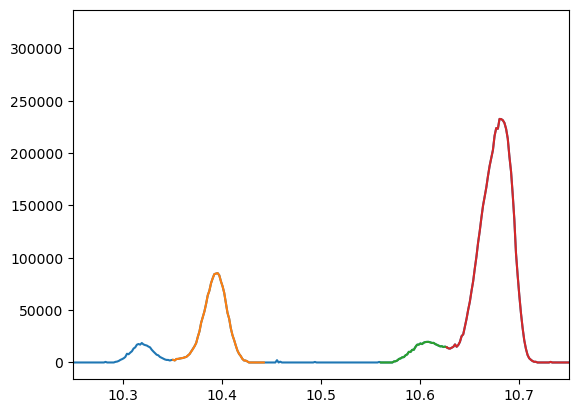

In [2]:
data_file = (
    "example_data/Example/ExperimentalData/ExampleChromatograms/chrom_001.csv"
)

chrom = chrom_from_csv(data_file)

region = [10.25, 10.75]

peaks = find_peaks_in_region(chrom, *region, threshold=0.07, wlen = 15, distance =10)
chrom.add_peaks(peaks)

plt.plot(chrom.time, chrom.signal)
for p in chrom.peaks:
    peak = chrom.peaks[p]
    plt.plot(chrom.time[peak.indices], chrom.signal[peak.indices])
_ = plt.xlim(*region)

Run the deconvolution operation. Note that the number of peaks to be fitted can be specified, but it does not necessarily have to be the same as the number of peaks in the chromatogram. Preferably, the two are equal.

The result is an array with a row for each picked peak, containing the peak magnitude, position, standard deviation (width) and baseline.

If there are peaks that you would like to deconvolute, but are having trouble detecting automatically, you can add a list of bounds where you expect the peaks to be by using the `peak_bound_estimates` key word argument. Make sure to enter enough peaks for the `num_peaks`key word argument. The bounds in `peak_bound_estimates` are only used if more peaks are specified for `num_peaks` than are stored in the chromatogram.

In [3]:
deconvoluted_peaks = deconvolute_region(chrom, region, num_peaks=4, peak_bound_estimates= [[10.25, 10.35]])
chrom.add_peaks(deconvoluted_peaks)

Now plot the results.

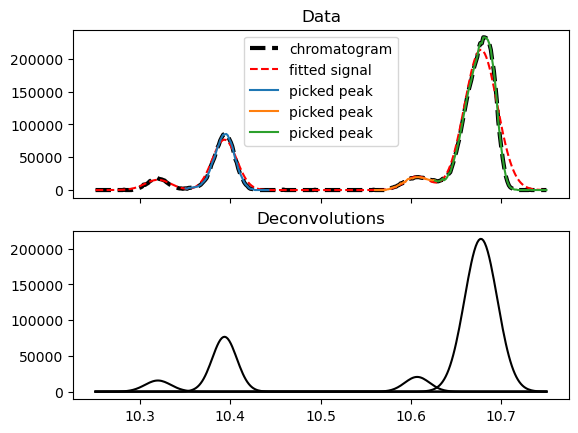

In [4]:
from scipy.stats import norm
fig, ax = plt.subplots(nrows=2, sharex=True)

# Cut out the region of the chromatogram that was deconvoluted
inds = np.where((chrom.time > region[0]) & (chrom.time < region[1]))[0]

time = chrom.time[(chrom.time > region[0])&(chrom.time< region[1])]
signal = chrom.signal[(chrom.time > region[0])&(chrom.time< region[1])]

ax[0].plot(time, signal, "--", label = "chromatogram", c="k", linewidth=3)

sum_deconvoluted_signal = np.zeros(len(time))
for p in chrom.deconvoluted_peaks:
    peak = chrom.deconvoluted_peaks[p]

    params = peak.deconvolution_params.parameters

    mag = params["magnitude"]
    loc = params["loc"]
    scale = params["scale"]
    baseline = params["baseline"]

    deconv_sig =  mag*norm.pdf(time, loc = loc, scale=scale) + baseline

    ax[1].plot(time, deconv_sig, c = "k")
    
    sum_deconvoluted_signal += deconv_sig

ax[0].plot(time, sum_deconvoluted_signal, "--", c = "r", label = "fitted signal")

for p in chrom.peaks:
    peak = chrom.peaks[p]
    ax[0].plot(chrom.time[peak.indices], chrom.signal[peak.indices], label = "picked peak")
        

ax[0].legend()
ax[0].set_title("Data")
ax[1].set_title("Deconvolutions")
plt.show()

That's one way of doing it. Other deconvolution methods are possible. Kernel Density Estimation (KDE) and Gaussian are related methods (which may effectively be the same? They seem to be identical in principle). Multidimensional methods include Biller and Bielmann (1974) and using PARAFAC ([tensorly](http://tensorly.org/stable/index.html) provides a convenient interface to PARAFAC, as used in [Mocca](https://github.com/HaasCP/mocca)).